# UMAP 

This script generates UMAP representations from spectrograms (previously generated).

### Installing and loading libraries

In [1]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle
import umap
from pathlib import Path
import datetime
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import librosa.display
from scipy.spatial.distance import pdist, squareform

In [2]:
from plot_functions import umap_2Dplot, mara_3Dplot, plotly_viz
from preprocessing_functions import pad_spectro, calc_zscore, preprocess_spec_numba, create_padded_data

### Setting constants

Setting project, input and output folders.

In [3]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")

DF_DICT = {}
for dftype in ['full', 'reduced', 'balanced']:
    DF_DICT[dftype] = os.path.join(os.path.sep, DATA, "df_focal_"+dftype+".pkl")

In [4]:
LOAD_EXISTING = True # if true, load existing embedding instead of creating new
OVERWRITE_FIGURES = False # if true, overwrite existing figures

# UMAP projection

### Choose dataset

In [5]:
#dftype='full'
dftype='reduced'
#dftype='balanced'

spec_df = pd.read_pickle(DF_DICT[dftype])
labels = spec_df.call_lable.values
spec_df.shape

(6430, 34)

### Choose feature

In [6]:
specs = spec_df.spectrograms.copy()
specs = [calc_zscore(x) for x in specs] 
data = create_padded_data(specs)

## Run UMAP

In [7]:
# 3D

embedding_filename = os.path.join(os.path.sep, DATA,'basic_UMAP_3D_'+dftype+'_default_params.csv')
print(embedding_filename)
if (LOAD_EXISTING and os.path.isfile(embedding_filename)):
    embedding = np.loadtxt(embedding_filename, delimiter=";")
    print("File already exists")
else:
    reducer = umap.UMAP(n_components=3, min_dist = 0, random_state=2204)
    embedding = reducer.fit_transform(data)
    np.savetxt(embedding_filename, embedding, delimiter=";")

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/basic_UMAP_3D_reduced_default_params.csv
File already exists


In [8]:
# 2D

embedding_filename = os.path.join(os.path.sep, DATA,'basic_UMAP_2D_'+dftype+'_default_params.csv')
print(embedding_filename)
if (LOAD_EXISTING and os.path.isfile(embedding_filename)):
    embedding2D = np.loadtxt(embedding_filename, delimiter=";")
    print("File already exists")
else:
    reducer = umap.UMAP(n_components=2, min_dist = 0, random_state=2204)
    embedding2D = reducer.fit_transform(data)
    np.savetxt(embedding_filename, embedding2D, delimiter=";")

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/basic_UMAP_2D_reduced_default_params.csv
File already exists


## Visualization

In [9]:
pal="Set2"

### 2D Plots

None


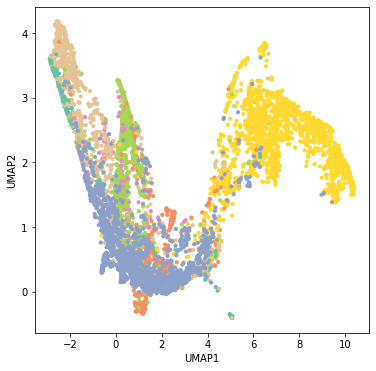

In [10]:
if OVERWRITE_FIGURES:
    outname = os.path.join(os.path.sep, FIGURES, 'UMAP_2D_plot_'+dftype+'_nolegend.jpg')
else:
    outname=None
    
print(outname)
umap_2Dplot(embedding2D[:,0], embedding2D[:,1], labels, pal, outname=outname, showlegend=False)

### 3D Plot

#### Matplotlib 

None


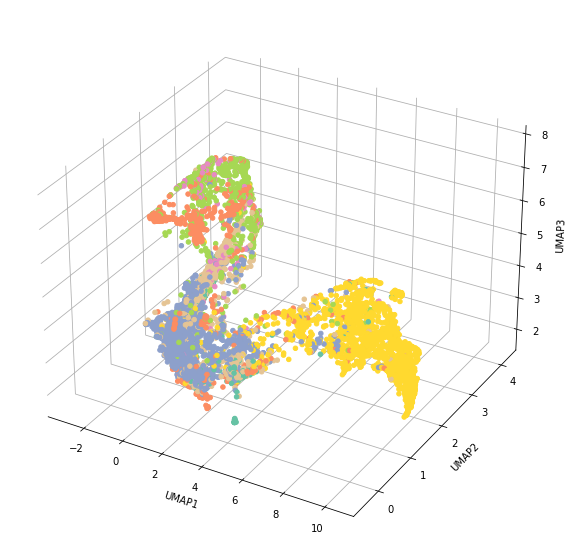

In [11]:
if OVERWRITE_FIGURES:
    outname = os.path.join(os.path.sep, FIGURES, 'UMAP_3D_plot_'+dftype+'_nolegend.jpg')
else:
    outname=None
    
    
print(outname)
mara_3Dplot(embedding[:,0],
            embedding[:,1],
            embedding[:,2],
            labels,
            pal,
            outname,
            showlegend=False)

#### Plotly

Interactive viz in plotly (though without sound or spectrogram)

In [13]:
#plotly_viz(embedding[:,0],
#           embedding[:,1],
#           embedding[:,2],
#           labels,
#           pal)

## Paper figure


In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
import matplotlib
import seaborn as sns

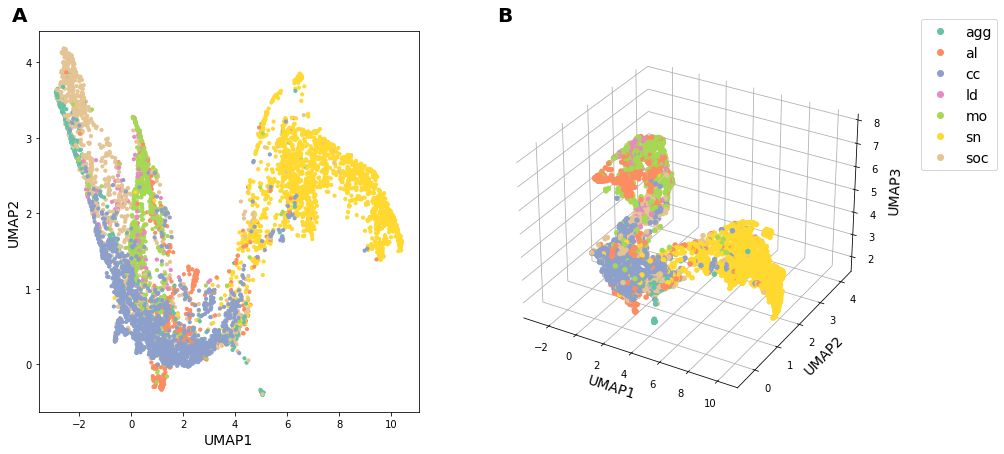

In [68]:
plt.figure(figsize=(15,7), facecolor="white")

labeltypes = sorted(list(set(labels)))
pal = sns.color_palette(pal, n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in labels]

ax = plt.subplot(1,2,1)

plt.scatter(embedding2D[:,0], embedding2D[:,1], alpha=1,
                s=10, c=c)
plt.xlabel('UMAP1', fontsize=14)
plt.ylabel('UMAP2', fontsize=14)
#ax.figure.set_size_inches(12,6)
#plt.subplots_adjust(top=0.8, bottom=0.2, right=0.6)

ax = plt.subplot(1,2,2, projection='3d')
Axes3D.scatter(ax,
               xs = embedding[:,0],
               ys = embedding[:,1],
               zs = embedding[:,2],
               zdir='z',
               s=20,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('UMAP1', fontsize=14)
ax.set_ylabel('UMAP2', fontsize=14)
ax.set_zlabel('UMAP3', fontsize=14)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
    
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
ax.legend(scatters, labeltypes, numpoints = 1, fontsize=14, loc='upper left', bbox_to_anchor=(1.1,1.05))

plt.figtext(0.1,0.9, "A", size=20, weight='bold')
plt.figtext(0.55,0.9, "B", size=20, weight='bold')
plt.savefig(os.path.join(os.path.sep, FIGURES, 'paper_umaps.jpg'), facecolor="white",bbox_inches='tight')